# Time series classification of COVID-19 dynamics in the United States

This notebook accompanies the paper _Time series classification of COVID-19 dynamics in the United States_ by Chris von Csefalvay. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Users/csefalvayk/Developer/mobility-social-distancing-dti/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
np.random.seed = 42 # Hardcoded seed for reproducibility

## Preparing the data set

This paper uses the [Starschema COVID-19 Data Set](https://github.com/starschema/COVID-19-data) for US case count data. Data is imported and structured as a time series, then scaled to $\mu=0$ and $\sigma=1$ using `tslearn.preprocessing.TimeSeriesScalerMeanVariance`.

In [3]:
df = pd.read_csv("https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv")

/Users/csefalvayk/Developer/mobility-social-distancing-dti/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We filter for only confirmed cases in the US, and retain only three columns – the ISO3166-2 identifier, the date and the case count.

In [4]:
df = df[(df["ISO3166-1"] == "US")
        & (df["Case_Type"] == "Confirmed")][["ISO3166-2", "Date", "Cases"]]

We then convert dates to daily dates, for consistency's sake:

In [5]:
df.Date = df.Date.values.astype("M8[D]")

We then hierarchically index values using `groupby`, then pivot the table and fill days where no cases are reported (`NaN`s) with zeroes. We then difference it, and zero out the initial `NaN`s again.

In [6]:
df = df.groupby(["ISO3166-2", "Date"]).agg("sum").reset_index().pivot(
    index="Date", columns="ISO3166-2",
    values="Cases").fillna(0).diff().fillna(0)

In [7]:
ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(df.T).T

In [8]:
scaled_data = pd.DataFrame(ts_scaled.reshape(ts_scaled.shape[1],
                                             ts_scaled.shape[2]),
                           index=df.index,
                           columns=df.columns)

Restrict to continental US states:

In [9]:
CONUS = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "ID", "IL",
    "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO",
    "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR",
    "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI",
    "WY"
]

scaled_data = scaled_data.drop(
    [state for state in scaled_data.columns if state not in CONUS], axis=1)

## Soft-DTW k-means classification 

In [10]:
def classify_scaled_data(data, n_clusters=3, gamma=1e-2):
    sdtw_kmeans = TimeSeriesKMeans(n_clusters=n_clusters,
                                   metric="softdtw",
                                   metric_params={"gamma": gamma},
                                   verbose=True)

    y_p = sdtw_kmeans.fit_predict(data.T)

    return {data.columns[i]: y_p[i]
            for i in range(len(data.columns))}, y_p, sdtw_kmeans

In [11]:
def plot_data(data, y_p, sdtw_kmeans, save=True, m_factor=3):

    n_clusters = sdtw_kmeans.n_clusters
    fig = plt.figure(figsize=(n_clusters * m_factor,
                              1.41 * n_clusters * m_factor))
    fig.tight_layout(pad=3.0)

    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)

        # Plot state traces
        for i in range(len(data.columns)):
            if y_p[i] == yi:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(sdtw_kmeans.cluster_centers_[yi].ravel(),
                                index=data.index)
        plt.plot(c_center, "r-")

        plt.text(0.05,
                 0.85,
                 f"kNN cluster {yi + 1}",
                 transform=plt.gca().transAxes)
        plt.ylim(-3, 6)

    if save:
        plt.savefig("../paper/figures/ts_sdtw_clusters.pdf")

In [12]:
d_s, y_p_knn, sdtw_kmeans = classify_scaled_data(scaled_data,
                                                 n_clusters=3,
                                                 gamma=0.1)

547.927 --> 191.216 --> 191.539 --> 190.983 --> 191.921 --> 191.079 --> 191.712 --> 191.109 --> 191.536 --> 190.879 --> 191.349 --> 190.547 --> 191.017 --> 190.347 --> 190.744 --> 190.207 --> 190.598 --> 190.135 --> 190.500 --> 190.075 --> 190.433 --> 190.017 --> 190.365 --> 189.964 --> 190.308 --> 189.924 --> 190.241 --> 189.917 --> 190.182 --> 189.923 --> 190.129 --> 189.929 --> 190.099 --> 189.934 --> 190.072 --> 189.936 --> 190.057 --> 189.937 --> 190.045 --> 189.934 --> 190.044 --> 189.933 --> 190.048 --> 189.660 --> 190.290 --> 190.145 --> 190.044 --> 190.109 --> 190.041 --> 190.064 --> 


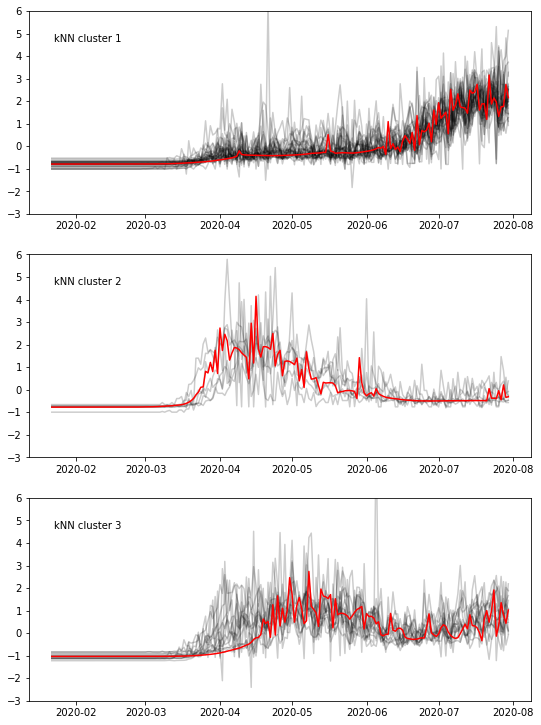

In [13]:
plot_data(scaled_data, y_p_knn, sdtw_kmeans)

## K-Shape classifier

In [14]:
def classify_scaled_data_kshape(data, n_clusters=3):
    ks = KShape(n_clusters,
                verbose=True,
                random_state=np.random.seed,
                n_init=16)

    y_p = ks.fit_predict(data.T)

    return {data.columns[i]: y_p[i] for i in range(len(data.columns))}, y_p, ks

In [15]:
def plot_ks(data, y_p, ks, save=True, m_factor=3):

    n_clusters = ks.n_clusters
    fig = plt.figure(figsize=(n_clusters * m_factor,
                              1.41 * n_clusters * m_factor))
    fig.tight_layout(pad=3.0)

    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)

        # Plot state traces
        for i in range(len(data.columns)):
            if y_p[i] == yi:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(ks.cluster_centers_[yi].ravel(),
                                index=data.index)
        plt.plot(c_center, "r-")

        plt.text(0.05,
                 0.85,
                 f"K-shape cluster {yi + 1}",
                 transform=plt.gca().transAxes)
        plt.ylim(-3, 6)

    if save:
        plt.savefig("../paper/figures/ts_ks_clusters.pdf")

In [16]:
d_s_ks, y_p_ks, ks_kmeans = classify_scaled_data_kshape(scaled_data,
                                                        n_clusters=3)

Init 1
0.037 --> 0.030 --> 0.029 --> 0.029 --> 0.028 --> 0.028 --> 
Init 2
0.033 --> 0.030 --> 0.031 --> 
Init 3
0.036 --> 0.034 --> 0.034 --> 0.034 --> 0.034 --> 
Init 4
Resumed because of empty cluster
Init 4
0.032 --> 0.032 --> 0.032 --> 0.031 --> 0.031 --> 0.031 --> 
Init 5
0.032 --> 0.026 --> 0.026 --> 
Init 6
0.027 --> 0.027 --> 0.026 --> 0.027 --> 
Init 7
0.034 --> 0.031 --> 0.031 --> 0.032 --> 
Init 8
0.028 --> 0.026 --> 0.026 --> 0.026 --> 
Init 9
0.043 --> 0.039 --> 0.037 --> 0.036 --> 0.034 --> 0.034 --> 0.033 --> 0.034 --> 
Init 10
0.036 --> 0.031 --> 0.028 --> 0.028 --> 
Init 11
0.074 --> 0.042 --> 0.036 --> 0.035 --> 0.035 --> 0.035 --> 0.034 --> 0.034 --> 
Init 12
0.029 --> 0.028 --> 0.028 --> 
Init 13
0.034 --> 0.029 --> 0.029 --> 0.029 --> 
Init 14
0.035 --> 0.033 --> 0.033 --> 
Init 15
0.039 --> 0.037 --> 0.035 --> 0.034 --> 0.033 --> 0.034 --> 


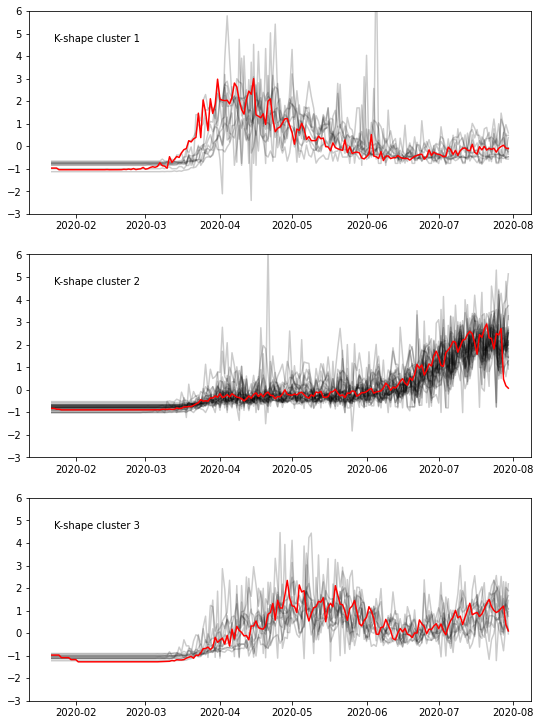

In [65]:
plot_ks(scaled_data, y_p_ks, ks_kmeans)

### Create choropleth clustering map

US States shapefile extracted from [here](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_5m.zip), courtesy of US Census Bureau.

In [18]:
import geopandas as gpd

In [19]:
def plot_map_with_clusters(map_df,
                           fn="clustering",
                           clustering_type="",
                           save=True):
    fig, ax = plt.subplots(1, figsize=(15, 6))
    map_df.plot(column="cluster",
                cmap="viridis",
                ax=ax,
                k=4,
                legend=True,
                linewidth=10)
    ax.set_ylim(23, 52.5)
    ax.set_xlim(-127, -60)

    leg = ax.get_legend()

    for i in range(max(map_df.cluster)):
        leg.get_texts()[i].set_text(f"{clustering_type} cluster {i + 1}")

    ax.axis("off")

    if save:
        plt.savefig(f"../paper/figures/{fn}.pdf")

In [20]:
def create_cluster_map(y_p, scaled_data, fn, clustering_type):
    map_df = gpd.read_file("cb_2019_us_state_5m.shp")[["STUSPS", "geometry"]]
    map_df.index = map_df.STUSPS
    map_df = map_df[["geometry"]]

    cluster_df = pd.DataFrame([y_p, scaled_data.columns]).T
    cluster_df.columns = ["cluster", "STUSPS"]
    cluster_df.cluster = cluster_df.cluster + 1
    cluster_df.index = cluster_df.STUSPS
    cluster_df = cluster_df[["cluster"]]

    map_df = map_df.join(cluster_df)

    plot_map_with_clusters(map_df, fn, clustering_type=clustering_type)

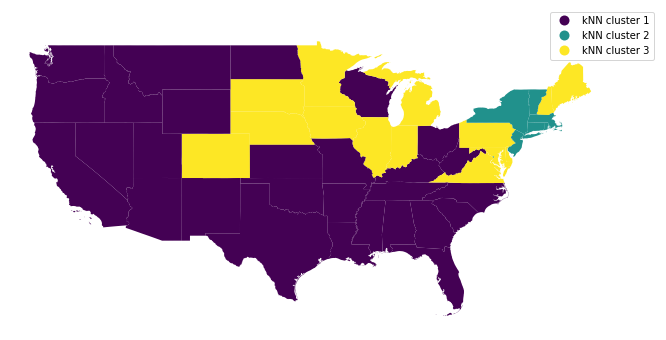

In [21]:
create_cluster_map(y_p_knn,
                   scaled_data,
                   fn="clustering_knn",
                   clustering_type="kNN")

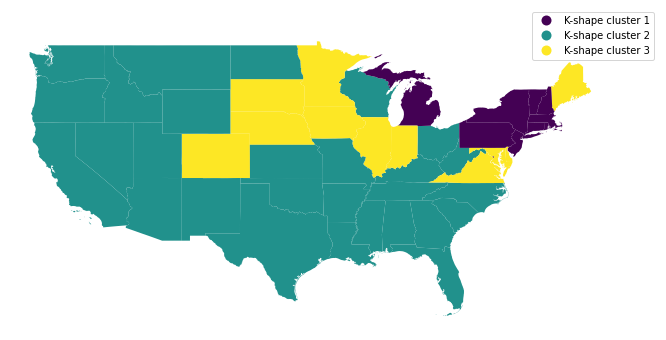

In [22]:
create_cluster_map(y_p_ks,
                   scaled_data,
                   fn="clustering_kshape",
                   clustering_type="K-shape")

## Calculate Rand index between the clusterings

In [23]:
from sklearn.metrics import adjusted_rand_score

In [24]:
adjusted_rand_score(y_p_ks, y_p_knn)

0.9052077238150965

## Plot correlation square

In [25]:
corrtab = pd.DataFrame([y_p_ks, y_p_knn]).T
corrtab.columns = ["k-shape", "kNN"]
corrtab["k-shape"] += 1
corrtab["kNN"] += 1

In [26]:
corrtab_pivoted = corrtab.pivot_table(columns="k-shape",
                                      index="kNN",
                                      aggfunc=len,
                                      fill_value=0)
corrtab_pivoted = corrtab_pivoted.div(corrtab_pivoted.sum().sum())

<AxesSubplot:xlabel='k-shape', ylabel='kNN'>

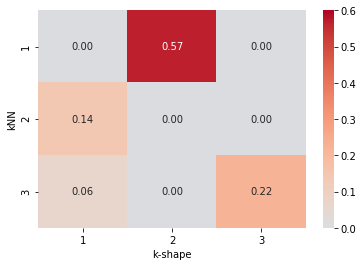

In [27]:
sns.heatmap(corrtab_pivoted,
            annot=True,
            vmin=0,
            vmax=0.6,
            center=0.01,
            cmap="coolwarm",
            fmt='.2f')

## Correlation adjusted side-by-side plots

In [52]:
    # Identify assignments
    corrtab = pd.DataFrame([y_p_ks, y_p_knn]).T
    corrtab.columns = ["k-shape", "kNN"]
    corrtab["k-shape"] += 1
    corrtab["kNN"] += 1
    
    corrtab_pivoted = corrtab.pivot_table(columns="k-shape",
                                      index="kNN",
                                      aggfunc=len,
                                      fill_value=0)
    corrtab_pivoted = corrtab_pivoted.div(corrtab_pivoted.sum().sum())



In [74]:
def plot_side_by_side(data,
                      y_p_ks,
                      y_p_knn,
                      ks_kmeans,
                      sdtw_kmeans,
                      m_factor: int = 4,
                      save: bool = True):
    n_clusters = ks_kmeans.n_clusters
    fig = plt.figure(figsize=(n_clusters * m_factor * 1.21,
                              n_clusters * m_factor))
    fig.tight_layout(pad=3.0)

    # Identify assignments
    corrtab = pd.DataFrame([y_p_ks, y_p_knn]).T
    corrtab.columns = ["k-shape", "kNN"]
    corrtab["k-shape"] += 1
    corrtab["kNN"] += 1

    corrtab_pivoted = corrtab.pivot_table(columns="k-shape",
                                          index="kNN",
                                          aggfunc=len,
                                          fill_value=0)
    corrtab_pivoted = corrtab_pivoted.div(
        corrtab_pivoted.sum().sum()).idxmax(axis=1)

    for yi in range(n_clusters):

        # left side plot: kNN
        plt.subplot(n_clusters, 2, (2 * yi) + 1)

        for i in range(len(data.columns)):
            if y_p_knn[i] == yi:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(sdtw_kmeans.cluster_centers_[yi].ravel(),
                                index=data.index)
        plt.plot(c_center, "r-")

        plt.text(0.05,
                 0.85,
                 f"kNN cluster {yi + 1}",
                 transform=plt.gca().transAxes)
        plt.ylim(-3, 6)

        # right side plot: k-shape
        idx = int(corrtab_pivoted[yi + 1])

        plt.subplot(n_clusters, 2, 2 * (yi + 1))

        for i in range(len(data.columns)):
            if y_p_ks[i] == idx - 1:
                plt.plot(data.iloc[:, i], "k-", alpha=.2)

        # Plot k-means barycenters
        c_center = pd.DataFrame(ks_kmeans.cluster_centers_[idx - 1].ravel(),
                                index=data.index)
        plt.plot(c_center, "r-")

        plt.text(0.05,
                 0.85,
                 f"k-shape cluster {idx}",
                 transform=plt.gca().transAxes)
        plt.ylim(-3, 6)
        
        if save:
            plt.savefig("../paper/figures/side-by-side.pdf")

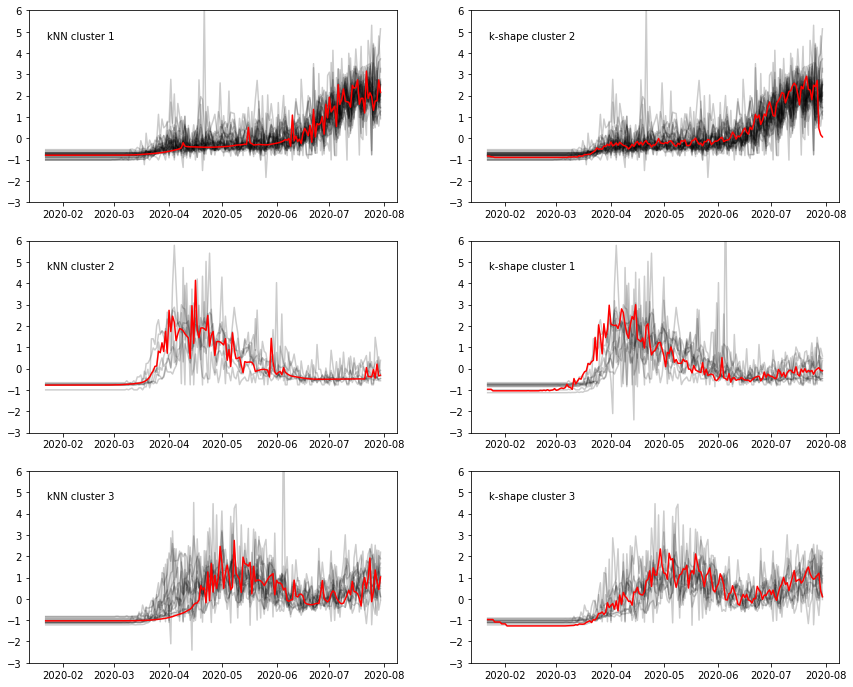

In [75]:
plot_side_by_side(scaled_data, y_p_ks, y_p_knn, ks_kmeans, sdtw_kmeans)